# Binary Classification Model for Homesite Quote Conversion Using Scikit-learn Take 1
### David Lowe
### June 1, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Homesite Quote Conversion dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: Homesite, a leading provider of homeowners' insurance, is looking for a dynamic conversion rate model that can give them indications of whether a quoted price will lead to a purchase. By using an anonymized database of information on customer and sales activity, the purpose of the exercise is to predict which customers will purchase a given quote. Accurate prediction of conversion would help Homesite better understand the impact of proposed pricing changes and maintain an ideal portfolio of customer segments. Submissions are evaluated on the area under the ROC curve between the predicted probability and the observed target.

In this Take1 iteration, we will construct and tune several machine learning models using the Scikit-learn library. Furthermore, we will apply the best-performing machine learning model to Kaggle's test dataset and submit a list of predictions for evaluation.

ANALYSIS: In this Take1 iteration, the performance of the machine learning algorithms achieved an average ROC-AUC of 92.02%. Two algorithms (Random Forest and Gradient Boosting) produced the top accuracy metrics after the first round of modeling. After a series of tuning trials, Gradient Boosting turned in a better overall result than Random Forest. Gradient Boosting achieved a ROC-AUC metric of 96.43%. When configured with the optimized parameters, the Gradient Boosting algorithm processed the test dataset with a ROC-AUC of 96.42%. However, when we applied the Gradient Boosting model to the test dataset from Kaggle, we obtained a ROC-AUC score of 96.52%.

CONCLUSION: For this iteration, the Gradient Boosting algorithm achieved the best overall results using the training and test datasets. For this dataset, we should continue to experiment with Gradient Boosting and other algorithms for our modeling effort.

Dataset Used: Homesite Quote Conversion Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/homesite-quote-conversion/data

One potential source of performance benchmark: https://www.kaggle.com/c/homesite-quote-conversion/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Environment

In [1]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


In [2]:
# Retrieve GPU configuration information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve memory configuration information from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

### 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
seedNum = 888

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import smtplib
from datetime import datetime
from email.message import EmailMessage
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import RFE
# from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTEENN
# from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from imblearn.ensemble import BalancedRandomForestClassifier
# from imblearn.ensemble import RUSBoostClassifier
# from imblearn.ensemble import BalancedBaggingClassifier
# from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = int(ncpu[0])

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
# scoring = 'accuracy'
scoring = 'roc_auc'

# Set Pandas options
pd.set_option("display.max_rows", 500)

In [7]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if (sender is None) or (receiver is None) or (gateway is None) or (smtpuser is None) or (password is None):
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [8]:
if notifyStatus: email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [9]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-homesite-quote-conversion/train.csv'
Xy_original = pd.read_csv(dataset_path, sep=',')

# Take a peek at the dataframe after import
Xy_original.head(10)

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,1,2013-08-16,0,B,23,0.9403,0.0006,965,1.0200,N,...,9,9,-1,8,-1,18,-1,10,N,CA
1,2,2014-04-22,0,F,7,1.0006,0.0040,548,1.2433,N,...,10,10,-1,11,-1,17,-1,20,N,NJ
2,4,2014-08-25,0,F,7,1.0006,0.0040,548,1.2433,N,...,15,18,-1,21,-1,11,-1,8,N,NJ
3,6,2013-04-15,0,J,10,0.9769,0.0004,"1,165",1.2665,N,...,6,5,-1,10,-1,9,-1,21,N,TX
4,8,2014-01-25,0,E,23,0.9472,0.0006,"1,487",1.3045,N,...,18,22,-1,10,-1,11,-1,12,N,IL
5,12,2014-01-18,0,E,14,0.9472,0.0006,"1,487",1.3045,N,...,10,11,-1,23,-1,25,-1,14,N,IL
6,13,2013-11-01,0,J,23,0.9258,0.0004,"1,165",1.2665,N,...,18,22,-1,19,-1,13,-1,8,N,TX
7,14,2014-05-14,0,B,25,0.9153,0.0007,935,1.0200,N,...,6,5,-1,3,-1,12,-1,13,N,CA
8,18,2013-06-19,0,J,10,0.9691,0.0004,"1,165",1.2665,N,...,2,1,-1,3,-1,2,-1,13,N,TX
9,19,2013-06-18,0,F,11,0.9919,0.0038,564,1.1886,N,...,10,11,-1,9,-1,22,-1,18,N,NJ


In [10]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260753 entries, 0 to 260752
Data columns (total 299 columns):
 #   Column                Dtype  
---  ------                -----  
 0   QuoteNumber           int64  
 1   Original_Quote_Date   object 
 2   QuoteConversion_Flag  int64  
 3   Field6                object 
 4   Field7                int64  
 5   Field8                float64
 6   Field9                float64
 7   Field10               object 
 8   Field11               float64
 9   Field12               object 
 10  CoverageField1A       int64  
 11  CoverageField1B       int64  
 12  CoverageField2A       int64  
 13  CoverageField2B       int64  
 14  CoverageField3A       int64  
 15  CoverageField3B       int64  
 16  CoverageField4A       int64  
 17  CoverageField4B       int64  
 18  CoverageField5A       int64  
 19  CoverageField5B       int64  
 20  CoverageField6A       int64  
 21  CoverageField6B       int64  
 22  CoverageField8        object 
 23  Coverage

In [11]:
Xy_original.describe()

,QuoteNumber,QuoteConversion_Flag,Field7,Field8,Field9,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,...,GeographicField58A,GeographicField58B,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B
count,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,...,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000
mean,217201.246011,0.187511,18.293339,0.938346,0.001451,1.162718,9.012533,13.000403,9.054005,13.015240,...,11.567756,12.985695,11.694903,13.049882,-0.350481,12.994362,-0.343601,13.042734,-0.341009,14.122948
std,125478.522633,0.390322,7.382803,0.037086,0.001486,0.116833,5.576509,7.219264,5.560521,7.211717,...,5.448425,7.216091,5.626092,7.213636,4.057792,7.219943,4.078673,7.145248,4.086511,5.829091
min,1.000000,0.000000,1.000000,0.874600,0.000400,1.000000,-1.000000,-1.000000,1.000000,1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,108517.000000,0.000000,11.000000,0.915300,0.000600,1.020000,5.000000,7.000000,5.000000,7.000000,...,8.000000,7.000000,7.000000,7.000000,-1.000000,7.000000,-1.000000,7.000000,-1.000000,8.000000
50%,217012.000000,0.000000,23.000000,0.940300,0.000600,1.188600,8.000000,13.000000,8.000000,13.000000,...,11.000000,13.000000,11.000000,13.000000,-1.000000,13.000000,-1.000000,13.000000,-1.000000,13.000000
75%,325905.000000,0.000000,24.000000,0.968500,0.003800,1.266500,12.000000,19.000000,12.000000,19.000000,...,15.000000,19.000000,15.000000,19.000000,-1.000000,19.000000,-1.000000,19.000000,-1.000000,19.000000
max,434588.000000,1.000000,28.000000,1.010100,0.004000,1.304500,25.000000,25.000000,25.000000,25.000000,...,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000


In [12]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

PersonalField7        113
PersonalField84    124208
PropertyField3         81
PropertyField4         63
PropertyField29    200685
PropertyField32        70
PropertyField34        70
PropertyField36       113
PropertyField38      1220
dtype: int64

In [13]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  326623


### 1.d) Data Cleaning

In [14]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'QuoteConversion_Flag': 'targetVar'})

# Dropping features due to lack of prediction value
Xy_original.drop(columns=['QuoteNumber','Original_Quote_Date'], inplace=True)
Xy_original.drop(columns=['PersonalField84','PropertyField29'], inplace=True)
Xy_original.drop(columns=['SalesField8'], inplace=True)

# Impute missing attributes with the "majority" value for each attribute
Xy_original['PersonalField7'].fillna('N', inplace=True)
Xy_original['PropertyField3'].fillna('N', inplace=True)
Xy_original['PropertyField4'].fillna('N', inplace=True)
Xy_original['PropertyField32'].fillna('Y', inplace=True)
Xy_original['PropertyField34'].fillna('Y', inplace=True)
Xy_original['PropertyField36'].fillna('N', inplace=True)
Xy_original['PropertyField38'].fillna('N', inplace=True)

# Correct non-ASCII characters in some attribute columns
Xy_original['GeographicField63'] = Xy_original['GeographicField63'].apply(lambda x: ''.join(["N" if ord(i) < 65 or ord(i) > 90 else i for i in x]))

# Correct mis-coding for some features
Xy_original.loc[(Xy_original.PersonalField16 == 'XN'), 'PersonalField16'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField16 == 'XU'), 'PersonalField16'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField16 == 'XY'), 'PersonalField16'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField16 == 'ZL'), 'PersonalField16'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField16 == 'ZO'), 'PersonalField16'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField16 == 'ZP'), 'PersonalField16'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField16 == 'ZQ'), 'PersonalField16'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField16 == 'ZS'), 'PersonalField16'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField16 == 'ZV'), 'PersonalField16'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField17 == 'XJ'), 'PersonalField17'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField17 == 'XO'), 'PersonalField17'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField17 == 'XP'), 'PersonalField17'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField17 == 'XY'), 'PersonalField17'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField17 == 'YP'), 'PersonalField17'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField17 == 'ZR'), 'PersonalField17'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField18 == 'XH'), 'PersonalField18'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField18 == 'XV'), 'PersonalField18'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField18 == 'ZG'), 'PersonalField18'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField18 == 'ZI'), 'PersonalField18'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField19 == 'XL'), 'PersonalField19'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField19 == 'YI'), 'PersonalField19'] = 'OTHER'
Xy_original.loc[(Xy_original.PersonalField19 == 'ZC'), 'PersonalField19'] = 'OTHER'
Xy_original.loc[(Xy_original.PropertyField7 == 'B'), 'PropertyField7'] = 'OTHER'

# Convert columns from one data type to another
Xy_original['Field6'] = Xy_original['Field6'].astype('category')
Xy_original['Field10'] = Xy_original['Field10'].str.replace(',','')
Xy_original['Field10'] = Xy_original['Field10'].astype('int')
Xy_original['Field12'] = Xy_original['Field12'].astype('category')
Xy_original['CoverageField8'] = Xy_original['CoverageField8'].astype('category')
Xy_original['CoverageField9'] = Xy_original['CoverageField9'].astype('category')
Xy_original['SalesField7'] = Xy_original['SalesField7'].astype('category')
Xy_original['PersonalField7'] = Xy_original['PersonalField7'].astype('category')
Xy_original['PersonalField16'] = Xy_original['PersonalField16'].astype('category')
Xy_original['PersonalField17'] = Xy_original['PersonalField17'].astype('category')
Xy_original['PersonalField18'] = Xy_original['PersonalField18'].astype('category')
Xy_original['PersonalField19'] = Xy_original['PersonalField19'].astype('category')
Xy_original['PropertyField3'] = Xy_original['PropertyField3'].astype('category')
Xy_original['PropertyField4'] = Xy_original['PropertyField4'].astype('category')
Xy_original['PropertyField5'] = Xy_original['PropertyField5'].astype('category')
Xy_original['PropertyField7'] = Xy_original['PropertyField7'].astype('category')
Xy_original['PropertyField14'] = Xy_original['PropertyField14'].astype('category')
Xy_original['PropertyField28'] = Xy_original['PropertyField28'].astype('category')
Xy_original['PropertyField30'] = Xy_original['PropertyField30'].astype('category')
Xy_original['PropertyField31'] = Xy_original['PropertyField31'].astype('category')
Xy_original['PropertyField32'] = Xy_original['PropertyField32'].astype('category')
Xy_original['PropertyField33'] = Xy_original['PropertyField33'].astype('category')
Xy_original['PropertyField34'] = Xy_original['PropertyField34'].astype('category')
Xy_original['PropertyField36'] = Xy_original['PropertyField36'].astype('category')
Xy_original['PropertyField37'] = Xy_original['PropertyField37'].astype('category')
Xy_original['PropertyField38'] = Xy_original['PropertyField38'].astype('category')
Xy_original['GeographicField63'] = Xy_original['GeographicField63'].astype('category')
Xy_original['GeographicField64'] = Xy_original['GeographicField64'].astype('category')

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,targetVar,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,0,B,23,0.9403,0.0006,965,1.0200,N,17,23,...,9,9,-1,8,-1,18,-1,10,N,CA
1,0,F,7,1.0006,0.0040,548,1.2433,N,6,8,...,10,10,-1,11,-1,17,-1,20,N,NJ
2,0,F,7,1.0006,0.0040,548,1.2433,N,7,12,...,15,18,-1,21,-1,11,-1,8,N,NJ
3,0,J,10,0.9769,0.0004,1165,1.2665,N,3,2,...,6,5,-1,10,-1,9,-1,21,N,TX
4,0,E,23,0.9472,0.0006,1487,1.3045,N,8,13,...,18,22,-1,10,-1,11,-1,12,N,IL
5,0,E,14,0.9472,0.0006,1487,1.3045,N,13,20,...,10,11,-1,23,-1,25,-1,14,N,IL
6,0,J,23,0.9258,0.0004,1165,1.2665,N,16,23,...,18,22,-1,19,-1,13,-1,8,N,TX
7,0,B,25,0.9153,0.0007,935,1.0200,N,5,8,...,6,5,-1,3,-1,12,-1,13,N,CA
8,0,J,10,0.9691,0.0004,1165,1.2665,N,5,8,...,2,1,-1,3,-1,2,-1,13,N,TX
9,0,F,11,0.9919,0.0038,564,1.1886,N,11,19,...,10,11,-1,9,-1,22,-1,18,N,NJ


In [15]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260753 entries, 0 to 260752
Data columns (total 294 columns):
 #   Column              Dtype   
---  ------              -----   
 0   targetVar           int64   
 1   Field6              category
 2   Field7              int64   
 3   Field8              float64 
 4   Field9              float64 
 5   Field10             int64   
 6   Field11             float64 
 7   Field12             category
 8   CoverageField1A     int64   
 9   CoverageField1B     int64   
 10  CoverageField2A     int64   
 11  CoverageField2B     int64   
 12  CoverageField3A     int64   
 13  CoverageField3B     int64   
 14  CoverageField4A     int64   
 15  CoverageField4B     int64   
 16  CoverageField5A     int64   
 17  CoverageField5B     int64   
 18  CoverageField6A     int64   
 19  CoverageField6B     int64   
 20  CoverageField8      category
 21  CoverageField9      category
 22  CoverageField11A    int64   
 23  CoverageField11B    int64   
 24 

In [16]:
Xy_original.describe()

,targetVar,Field7,Field8,Field9,Field10,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,...,GeographicField58A,GeographicField58B,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B
count,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,...,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000
mean,0.187511,18.293339,0.938346,0.001451,954.110829,1.162718,9.012533,13.000403,9.054005,13.015240,...,11.567756,12.985695,11.694903,13.049882,-0.350481,12.994362,-0.343601,13.042734,-0.341009,14.122948
std,0.390322,7.382803,0.037086,0.001486,290.571712,0.116833,5.576509,7.219264,5.560521,7.211717,...,5.448425,7.216091,5.626092,7.213636,4.057792,7.219943,4.078673,7.145248,4.086511,5.829091
min,0.000000,1.000000,0.874600,0.000400,548.000000,1.000000,-1.000000,-1.000000,1.000000,1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,11.000000,0.915300,0.000600,564.000000,1.020000,5.000000,7.000000,5.000000,7.000000,...,8.000000,7.000000,7.000000,7.000000,-1.000000,7.000000,-1.000000,7.000000,-1.000000,8.000000
50%,0.000000,23.000000,0.940300,0.000600,965.000000,1.188600,8.000000,13.000000,8.000000,13.000000,...,11.000000,13.000000,11.000000,13.000000,-1.000000,13.000000,-1.000000,13.000000,-1.000000,13.000000
75%,0.000000,24.000000,0.968500,0.003800,1113.000000,1.266500,12.000000,19.000000,12.000000,19.000000,...,15.000000,19.000000,15.000000,19.000000,-1.000000,19.000000,-1.000000,19.000000,-1.000000,19.000000
max,1.000000,28.000000,1.010100,0.004000,1487.000000,1.304500,25.000000,25.000000,25.000000,25.000000,...,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000


In [17]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [18]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [19]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

In [20]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (260753, 294) X_original.shape: (260753, 293) y_original.shape: (260753,)


### 1.f) Set up the parameters for data visualization

In [21]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [22]:
if notifyStatus: email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data

In [23]:
if notifyStatus: email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [24]:
X_original.head(10)

,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,B,23,0.9403,0.0006,965,1.0200,N,17,23,17,...,9,9,-1,8,-1,18,-1,10,N,CA
1,F,7,1.0006,0.0040,548,1.2433,N,6,8,6,...,10,10,-1,11,-1,17,-1,20,N,NJ
2,F,7,1.0006,0.0040,548,1.2433,N,7,12,7,...,15,18,-1,21,-1,11,-1,8,N,NJ
3,J,10,0.9769,0.0004,1165,1.2665,N,3,2,3,...,6,5,-1,10,-1,9,-1,21,N,TX
4,E,23,0.9472,0.0006,1487,1.3045,N,8,13,8,...,18,22,-1,10,-1,11,-1,12,N,IL
5,E,14,0.9472,0.0006,1487,1.3045,N,13,20,13,...,10,11,-1,23,-1,25,-1,14,N,IL
6,J,23,0.9258,0.0004,1165,1.2665,N,16,23,17,...,18,22,-1,19,-1,13,-1,8,N,TX
7,B,25,0.9153,0.0007,935,1.0200,N,5,8,5,...,6,5,-1,3,-1,12,-1,13,N,CA
8,J,10,0.9691,0.0004,1165,1.2665,N,5,8,6,...,2,1,-1,3,-1,2,-1,13,N,TX
9,F,11,0.9919,0.0038,564,1.1886,N,11,19,11,...,10,11,-1,9,-1,22,-1,18,N,NJ


#### 2.a.ii) Dimensions and attribute types

In [25]:
X_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260753 entries, 0 to 260752
Data columns (total 293 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Field6              category
 1   Field7              int64   
 2   Field8              float64 
 3   Field9              float64 
 4   Field10             int64   
 5   Field11             float64 
 6   Field12             category
 7   CoverageField1A     int64   
 8   CoverageField1B     int64   
 9   CoverageField2A     int64   
 10  CoverageField2B     int64   
 11  CoverageField3A     int64   
 12  CoverageField3B     int64   
 13  CoverageField4A     int64   
 14  CoverageField4B     int64   
 15  CoverageField5A     int64   
 16  CoverageField5B     int64   
 17  CoverageField6A     int64   
 18  CoverageField6B     int64   
 19  CoverageField8      category
 20  CoverageField9      category
 21  CoverageField11A    int64   
 22  CoverageField11B    int64   
 23  SalesField1A        int64   
 24 

#### 2.a.iii) Statistical summary of the attributes

In [26]:
X_original.describe()

,Field7,Field8,Field9,Field10,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,...,GeographicField58A,GeographicField58B,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B
count,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,...,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000
mean,18.293339,0.938346,0.001451,954.110829,1.162718,9.012533,13.000403,9.054005,13.015240,9.053150,...,11.567756,12.985695,11.694903,13.049882,-0.350481,12.994362,-0.343601,13.042734,-0.341009,14.122948
std,7.382803,0.037086,0.001486,290.571712,0.116833,5.576509,7.219264,5.560521,7.211717,5.579687,...,5.448425,7.216091,5.626092,7.213636,4.057792,7.219943,4.078673,7.145248,4.086511,5.829091
min,1.000000,0.874600,0.000400,548.000000,1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,11.000000,0.915300,0.000600,564.000000,1.020000,5.000000,7.000000,5.000000,7.000000,5.000000,...,8.000000,7.000000,7.000000,7.000000,-1.000000,7.000000,-1.000000,7.000000,-1.000000,8.000000
50%,23.000000,0.940300,0.000600,965.000000,1.188600,8.000000,13.000000,8.000000,13.000000,8.000000,...,11.000000,13.000000,11.000000,13.000000,-1.000000,13.000000,-1.000000,13.000000,-1.000000,13.000000
75%,24.000000,0.968500,0.003800,1113.000000,1.266500,12.000000,19.000000,12.000000,19.000000,12.000000,...,15.000000,19.000000,15.000000,19.000000,-1.000000,19.000000,-1.000000,19.000000,-1.000000,19.000000
max,28.000000,1.010100,0.004000,1487.000000,1.304500,25.000000,25.000000,25.000000,25.000000,25.000000,...,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000


#### 2.a.iv) Summarize the levels of the class attribute

In [27]:
Xy_original.groupby('targetVar').size()

targetVar
0    211859
1     48894
dtype: int64

### 2.b) Data Visualization

In [28]:
# Histograms for each attribute
# X_original.hist(layout=(dispRow,dispCol))
# plt.show()

In [29]:
# Box and Whisker plot for each attribute
# X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
# plt.show()

In [30]:
# Density plot for each attribute
# X_original.plot(kind='density', subplots=True, layout=(dispRow,dispCol))
# plt.show()

In [31]:
# Correlation matrix
# fig = plt.figure(figsize=(16,12))
# ax = fig.add_subplot(111)
# correlations = X_original.corr(method='pearson')
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# plt.show()

In [32]:
if notifyStatus: email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data

In [33]:
if notifyStatus: email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [34]:
columns_to_scale = ['Field8','Field9','Field10','Field11']
scaler = preprocessing.MinMaxScaler()
X_original[columns_to_scale] = scaler.fit_transform(X_original[columns_to_scale])

print(X_original.head(-10))

       Field6  Field7    Field8    Field9   Field10   Field11 Field12  \
0           B      23  0.484871  0.055556  0.444089  0.065681       N   
1           F       7  0.929889  1.000000  0.000000  0.799015       N   
2           F       7  0.929889  1.000000  0.000000  0.799015       N   
3           J      10  0.754982  0.000000  0.657082  0.875205       N   
4           E      23  0.535793  0.055556  1.000000  1.000000       N   
...       ...     ...       ...       ...       ...       ...     ...   
260738      E      23  0.476753  0.055556  1.000000  1.000000       N   
260739      B      25  0.484871  0.083333  0.412141  0.065681       N   
260740      J      10  0.697417  0.000000  0.657082  0.875205       N   
260741      F      23  0.204428  0.944444  0.017039  0.220033       N   
260742      B      24  0.484871  0.055556  0.444089  0.065681       N   

        CoverageField1A  CoverageField1B  CoverageField2A  ...  \
0                    17               23               17

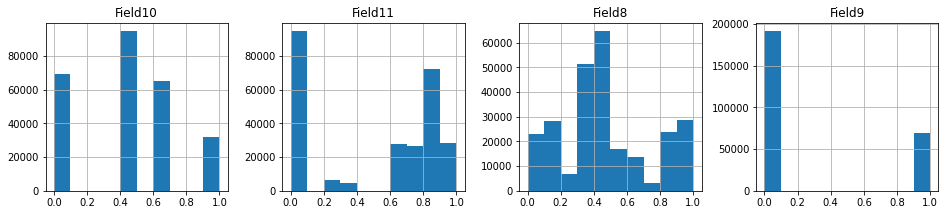

In [35]:
# Histograms for each pre-processed attribute
X_original[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

### 3.b) Training Data Balancing

In [36]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [37]:
# Not applicable for this iteration of the project

### 3.d) Splitting Data into Training and Test Sets

In [38]:
# Not applicable for this iteration of the project
# Perform one-hot-encoding on the categorical attributes
X_original = pd.get_dummies(X_original)
X_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260753 entries, 0 to 260752
Data columns (total 580 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Field7                 int64  
 1   Field8                 float64
 2   Field9                 float64
 3   Field10                float64
 4   Field11                float64
 5   CoverageField1A        int64  
 6   CoverageField1B        int64  
 7   CoverageField2A        int64  
 8   CoverageField2B        int64  
 9   CoverageField3A        int64  
 10  CoverageField3B        int64  
 11  CoverageField4A        int64  
 12  CoverageField4B        int64  
 13  CoverageField5A        int64  
 14  CoverageField5B        int64  
 15  CoverageField6A        int64  
 16  CoverageField6B        int64  
 17  CoverageField11A       int64  
 18  CoverageField11B       int64  
 19  SalesField1A           int64  
 20  SalesField1B           int64  
 21  SalesField2A           int64  
 22  SalesField2B       

In [39]:
# Split the data further into training and test datasets
if splitDataset:
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=splitPercentage, 
                                                                    stratify=y_original, random_state=seedNum)
else:
    X_train_df, y_train_df = X_original, y_original
    X_test_df, y_test_df = X_original, y_original
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (195564, 580) y_train_df.shape: (195564,)
X_test_df.shape: (65189, 580) y_test_df.shape: (65189,)


### 3.e) Display the Final Datasets for Model-Building

In [40]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (195564, 580) y_train.shape: (195564,)
X_test.shape: (65189, 580) y_test.shape: (65189,)


In [41]:
if notifyStatus: email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 4. Model and Evaluate Algorithms

### 4.a) Set test options and evaluation metric

In [42]:
# Set up Algorithms Spot-Checking Array
startTimeModule = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LGR', LogisticRegression(random_state=seedNum)))
train_models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
train_models.append(('BGT', BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('RNF', RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
# train_models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=n_jobs, tree_method='gpu_hist')))

In [43]:
# Generate model in turn
for name, model in train_models:
	if notifyStatus: email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if notifyStatus: email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeModule))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   48.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LGR: 0.901791 (0.002195)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=888, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Model training time: 0:00:48.628315 



[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CART: 0.821535 (0.002501)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=888, splitter='best')
Model training time: 0:02:19.181967 



[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 10.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


BGT: 0.935091 (0.000885)
BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10, n_jobs=4,
                  oob_score=False, random_state=888, verbose=0,
                  warm_start=False)
Model training time: 0:10:06.685926 



[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  4.4min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RNF: 0.951451 (0.000851)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=888, verbose=0,
                       warm_start=False)
Model training time: 0:04:25.619368 



[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  4.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


EXT: 0.949504 (0.000819)
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                     oob_score=False, random_state=888, verbose=0,
                     warm_start=False)
Model training time: 0:04:18.824600 

GBM: 0.958217 (0.000594)
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
               

[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 41.7min finished


### 4.b) Spot-checking baseline algorithms

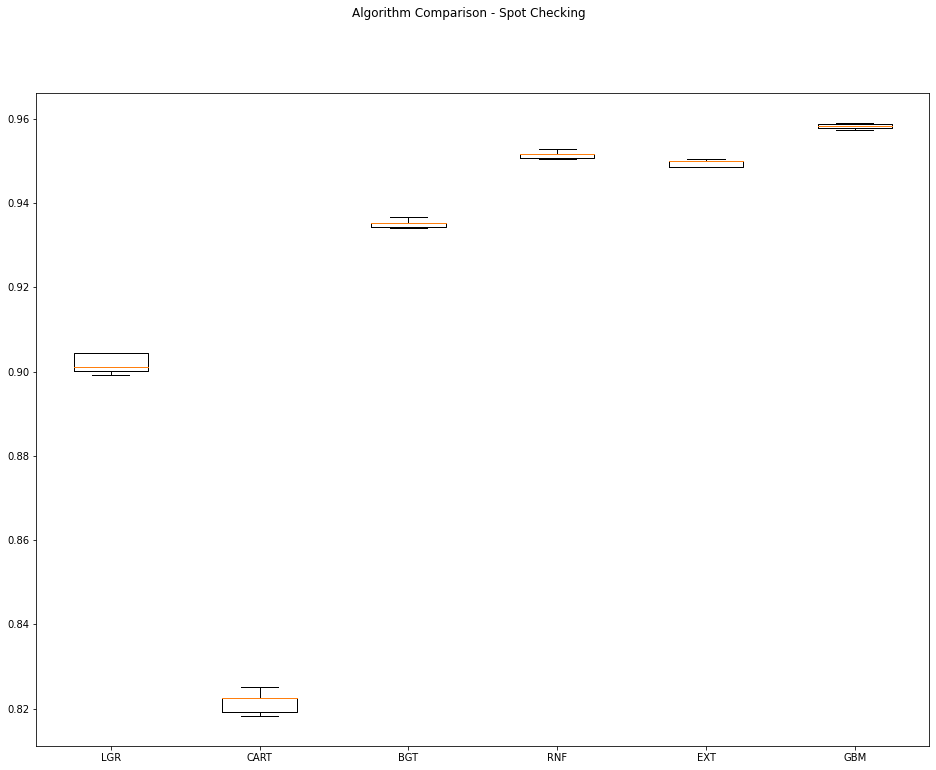

In [44]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

## Section 5 - Improve Accuracy

### 5.a) Algorithm Tuning

In [45]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [46]:
# Tuning algorithm #1 - Random Forest
startTimeModule = datetime.now()
if notifyStatus: email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_model_names.append('RNF')
paramGrid1 = dict(n_estimators=np.array([100, 300, 500, 700, 900]))

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 100.9min finished


Best: 0.954012 using {'n_estimators': 900}
0.951451 (0.000851) with: {'n_estimators': 100}
0.953373 (0.000754) with: {'n_estimators': 300}
0.953714 (0.000764) with: {'n_estimators': 500}
0.953918 (0.000759) with: {'n_estimators': 700}
0.954012 (0.000748) with: {'n_estimators': 900}
Model training time: 1:49:53.925929


In [47]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 900


In [48]:
# Tuning algorithm #2 - Gradient Boosting
startTimeModule = datetime.now()
if notifyStatus: email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = GradientBoostingClassifier(random_state=seedNum)
tune_model_names.append('GBM')
paramGrid2 = dict(n_estimators=np.array([100, 300, 500, 700, 900]))

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 719.0min finished


Best: 0.964309 using {'n_estimators': 900}
0.958217 (0.000594) with: {'n_estimators': 100}
0.962763 (0.000698) with: {'n_estimators': 300}
0.963696 (0.000734) with: {'n_estimators': 500}
0.964123 (0.000756) with: {'n_estimators': 700}
0.964309 (0.000767) with: {'n_estimators': 900}
Model training time: 14:33:49.776525


In [49]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 900


### 5.b) Compare Algorithms After Tuning

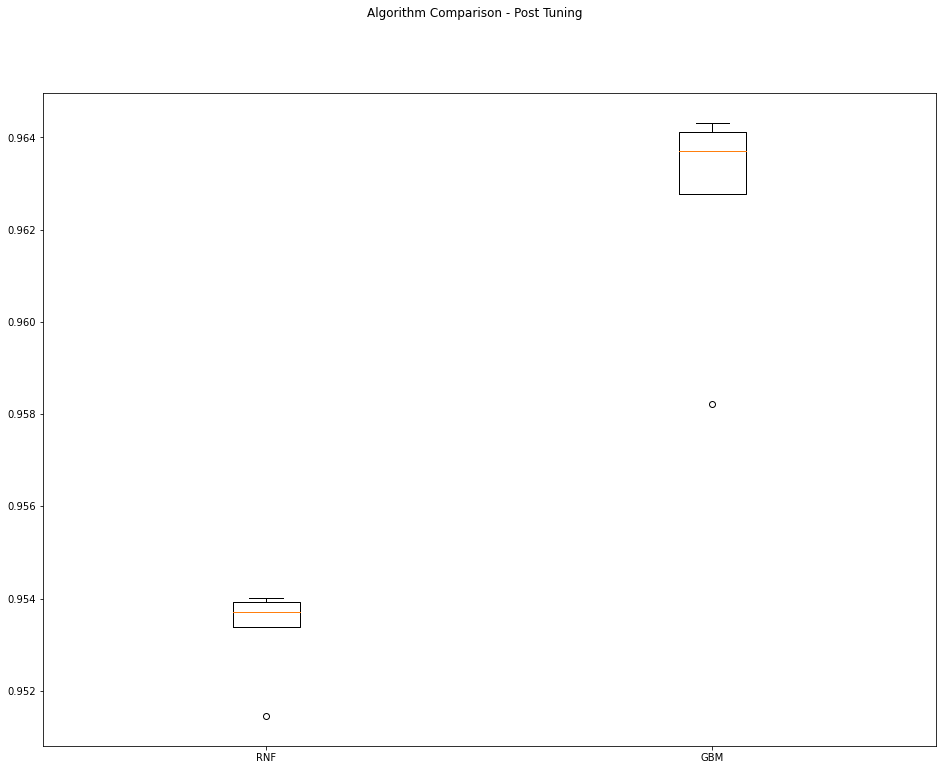

In [50]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

## Section 6 - Finalize Model

In [51]:
if notifyStatus: email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Measure predictions from the test dataset

In [52]:
test_model1 = RandomForestClassifier(n_estimators=best_paramValue1, random_state=seedNum, n_jobs=n_jobs)
test_model1.fit(X_train, y_train)
predictions1 = test_model1.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions1))
probability1 = test_model1.predict_proba(X_test)[:,1]
print('ROC/AUC Score:', roc_auc_score(y_test, probability1))
print(confusion_matrix(y_test, predictions1))
print(classification_report(y_test, predictions1))
print(test_model1)

Accuracy Score: 0.9125926153185353
ROC/AUC Score: 0.9539103202351845
[[52125   840]
 [ 4858  7366]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95     52965
           1       0.90      0.60      0.72     12224

    accuracy                           0.91     65189
   macro avg       0.91      0.79      0.83     65189
weighted avg       0.91      0.91      0.91     65189

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=4,
                       oob_score=False, random_state=888, verbose=0,
                       warm_start=False)


In [53]:
test_model2 = GradientBoostingClassifier(n_estimators=best_paramValue2, random_state=seedNum)
test_model2.fit(X_train, y_train)
predictions2 = test_model2.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions2))
probability2 = test_model2.predict_proba(X_test)[:,1]
print('ROC/AUC Score:', roc_auc_score(y_test, probability2))
print(confusion_matrix(y_test, predictions2))
print(classification_report(y_test, predictions2))
print(test_model2)

Accuracy Score: 0.9262298854101152
ROC/AUC Score: 0.9642120920513053
[[51938  1027]
 [ 3782  8442]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     52965
           1       0.89      0.69      0.78     12224

    accuracy                           0.93     65189
   macro avg       0.91      0.84      0.87     65189
weighted avg       0.92      0.93      0.92     65189

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=900,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=888, subsample=1.

### 6.b) Create a standalone model using all available data

In [54]:
# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
X_complete = np.vstack((X_train, X_test))
y_complete = np.concatenate((y_train, y_test))
print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
final_model = test_model2.fit(X_complete, y_complete)
print(final_model)

X_complete.shape: (260753, 580) y_complete.shape: (260753,)
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=900,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=888, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


### 6.c) Create Submission Files for Kaggle Evaluation

In [55]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-homesite-quote-conversion/test.csv'
X_kaggle_data = pd.read_csv(dataset_path, sep=',')

# Take a peek at the dataframe after import
X_kaggle_data.head(10)

,QuoteNumber,Original_Quote_Date,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,3,2014-08-12,E,16,0.9364,0.0006,"1,487",1.3045,N,4,...,1,1,-1,1,-1,20,-1,25,Y,IL
1,5,2013-09-07,F,11,0.9919,0.0038,564,1.1886,N,8,...,10,10,-1,5,-1,5,-1,21,N,NJ
2,7,2013-03-29,F,15,0.8945,0.0038,564,1.0670,N,11,...,10,11,-1,20,-1,22,-1,11,N,NJ
3,9,2015-03-21,K,21,0.8870,0.0004,"1,113",1.2665,Y,14,...,8,8,-1,13,-1,8,-1,21,N,TX
4,10,2014-12-10,B,25,0.9153,0.0007,935,1.0200,N,4,...,7,7,-1,3,-1,22,-1,21,N,CA
5,11,2013-07-19,B,24,0.9403,0.0006,965,1.0200,N,11,...,9,9,-1,2,-1,20,-1,8,N,CA
6,15,2014-07-28,E,23,0.9392,0.0006,"1,487",1.3045,N,5,...,11,12,-1,7,-1,4,-1,8,N,IL
7,16,2015-01-20,B,25,0.9153,0.0007,935,1.0200,N,6,...,15,19,-1,17,-1,15,-1,8,N,CA
8,17,2014-05-28,J,23,0.8928,0.0004,"1,113",1.2665,N,12,...,7,7,-1,12,-1,5,-1,8,N,TX
9,21,2013-07-11,J,23,0.9691,0.0004,"1,165",1.2665,N,3,...,7,6,-1,1,-1,8,-1,13,N,TX


In [56]:
# Set up the dataframe to capture predictions for Kaggle submission
y_submission_kaggle = pd.DataFrame(columns=['QuoteNumber', 'QuoteConversion_Flag'])
y_submission_kaggle['QuoteNumber'] = X_kaggle_data['QuoteNumber']
y_submission_kaggle.head()

,QuoteNumber,QuoteConversion_Flag
0,3,NaN
1,5,NaN
2,7,NaN
3,9,NaN
4,10,NaN


In [57]:
# Check to see whether the test dataset contains any NaN
null_counts = X_kaggle_data.isnull().sum()
null_counts[null_counts > 0]

PersonalField7         69
PersonalField84     82812
PropertyField3         69
PropertyField4         52
PropertyField5          1
PropertyField29    133945
PropertyField30         1
PropertyField32        41
PropertyField34        41
PropertyField36        67
PropertyField38       846
dtype: int64

In [58]:
print('Total number of NaN in the dataframe: ', X_kaggle_data.isnull().sum().sum())

Total number of NaN in the dataframe:  217944


In [59]:
# Apply the same data pre-processing steps to the test data
X_kaggle_data.drop(columns=['QuoteNumber','Original_Quote_Date'], inplace=True)
X_kaggle_data.drop(columns=['PersonalField84','PropertyField29'], inplace=True)
X_kaggle_data.drop(columns=['SalesField8'], inplace=True)

# Impute missing attributes with the "majority" value for each attribute
X_kaggle_data['PersonalField7'].fillna('N', inplace=True)
X_kaggle_data['PropertyField3'].fillna('N', inplace=True)
X_kaggle_data['PropertyField4'].fillna('N', inplace=True)
X_kaggle_data['PropertyField5'].fillna('Y', inplace=True)
X_kaggle_data['PropertyField30'].fillna('N', inplace=True)
X_kaggle_data['PropertyField32'].fillna('Y', inplace=True)
X_kaggle_data['PropertyField34'].fillna('Y', inplace=True)
X_kaggle_data['PropertyField36'].fillna('N', inplace=True)
X_kaggle_data['PropertyField38'].fillna('N', inplace=True)

# Correct non-ASCII characters in some attribute columns
X_kaggle_data['PropertyField37'] = X_kaggle_data['PropertyField37'].apply(lambda x: ''.join(["N" if ord(i) < 65 or ord(i) > 90 else i for i in x]))
X_kaggle_data['GeographicField63'] = X_kaggle_data['GeographicField63'].apply(lambda x: ''.join(["N" if ord(i) < 65 or ord(i) > 90 else i for i in x]))

# Correct mis-coding for some features
X_kaggle_data.loc[(X_kaggle_data.PersonalField16 == 'XG'), 'PersonalField16'] = 'OTHER'
X_kaggle_data.loc[(X_kaggle_data.PersonalField16 == 'YG'), 'PersonalField16'] = 'OTHER'
X_kaggle_data.loc[(X_kaggle_data.PersonalField16 == 'ZM'), 'PersonalField16'] = 'OTHER'
X_kaggle_data.loc[(X_kaggle_data.PersonalField17 == 'XF'), 'PersonalField17'] = 'OTHER'
X_kaggle_data.loc[(X_kaggle_data.PersonalField17 == 'XZ'), 'PersonalField17'] = 'OTHER'
X_kaggle_data.loc[(X_kaggle_data.PersonalField17 == 'YO'), 'PersonalField17'] = 'OTHER'
X_kaggle_data.loc[(X_kaggle_data.PersonalField17 == 'ZJ'), 'PersonalField17'] = 'OTHER'
X_kaggle_data.loc[(X_kaggle_data.PersonalField18 == 'XB'), 'PersonalField18'] = 'OTHER'
X_kaggle_data.loc[(X_kaggle_data.PersonalField19 == 'ZS'), 'PersonalField19'] = 'OTHER'
X_kaggle_data.loc[(X_kaggle_data.PropertyField7 == 'T'), 'PropertyField7'] = 'OTHER'

# Convert columns from one data type to another
X_kaggle_data['Field6'] = X_kaggle_data['Field6'].astype('category')
X_kaggle_data['Field10'] = X_kaggle_data['Field10'].str.replace(',','')
X_kaggle_data['Field10'] = X_kaggle_data['Field10'].astype('int')
X_kaggle_data['Field12'] = X_kaggle_data['Field12'].astype('category')
X_kaggle_data['CoverageField8'] = X_kaggle_data['CoverageField8'].astype('category')
X_kaggle_data['CoverageField9'] = X_kaggle_data['CoverageField9'].astype('category')
X_kaggle_data['SalesField7'] = X_kaggle_data['SalesField7'].astype('category')
X_kaggle_data['PersonalField7'] = X_kaggle_data['PersonalField7'].astype('category')
X_kaggle_data['PersonalField16'] = X_kaggle_data['PersonalField16'].astype('category')
X_kaggle_data['PersonalField17'] = X_kaggle_data['PersonalField17'].astype('category')
X_kaggle_data['PersonalField18'] = X_kaggle_data['PersonalField18'].astype('category')
X_kaggle_data['PersonalField19'] = X_kaggle_data['PersonalField19'].astype('category')
X_kaggle_data['PropertyField3'] = X_kaggle_data['PropertyField3'].astype('category')
X_kaggle_data['PropertyField4'] = X_kaggle_data['PropertyField4'].astype('category')
X_kaggle_data['PropertyField5'] = X_kaggle_data['PropertyField5'].astype('category')
X_kaggle_data['PropertyField7'] = X_kaggle_data['PropertyField7'].astype('category')
X_kaggle_data['PropertyField14'] = X_kaggle_data['PropertyField14'].astype('category')
X_kaggle_data['PropertyField28'] = X_kaggle_data['PropertyField28'].astype('category')
X_kaggle_data['PropertyField30'] = X_kaggle_data['PropertyField30'].astype('category')
X_kaggle_data['PropertyField31'] = X_kaggle_data['PropertyField31'].astype('category')
X_kaggle_data['PropertyField32'] = X_kaggle_data['PropertyField32'].astype('category')
X_kaggle_data['PropertyField33'] = X_kaggle_data['PropertyField33'].astype('category')
X_kaggle_data['PropertyField34'] = X_kaggle_data['PropertyField34'].astype('category')
X_kaggle_data['PropertyField36'] = X_kaggle_data['PropertyField36'].astype('category')
X_kaggle_data['PropertyField37'] = X_kaggle_data['PropertyField37'].astype('category')
X_kaggle_data['PropertyField38'] = X_kaggle_data['PropertyField38'].astype('category')
X_kaggle_data['GeographicField63'] = X_kaggle_data['GeographicField63'].astype('category')
X_kaggle_data['GeographicField64'] = X_kaggle_data['GeographicField64'].astype('category')

X_kaggle_data[columns_to_scale] = scaler.fit_transform(X_kaggle_data[columns_to_scale])

X_kaggle_data.head(10)

,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,E,16,0.456089,0.055556,1.000000,1.000000,N,4,4,4,...,1,1,-1,1,-1,20,-1,25,Y,IL
1,F,11,0.865683,0.944444,0.017039,0.619376,N,8,14,8,...,10,10,-1,5,-1,5,-1,21,N,NJ
2,F,15,0.146863,0.944444,0.017039,0.220033,N,11,18,11,...,10,11,-1,20,-1,22,-1,11,N,NJ
3,K,21,0.091513,0.000000,0.601704,0.875205,Y,14,22,15,...,8,8,-1,13,-1,8,-1,21,N,TX
4,B,25,0.300369,0.083333,0.412141,0.065681,N,4,5,4,...,7,7,-1,3,-1,22,-1,21,N,CA
5,B,24,0.484871,0.055556,0.444089,0.065681,N,11,18,11,...,9,9,-1,2,-1,20,-1,8,N,CA
6,E,23,0.476753,0.055556,1.000000,1.000000,N,5,6,5,...,11,12,-1,7,-1,4,-1,8,N,IL
7,B,25,0.300369,0.083333,0.412141,0.065681,N,6,9,6,...,15,19,-1,17,-1,15,-1,8,N,CA
8,J,23,0.134317,0.000000,0.601704,0.875205,N,12,20,12,...,7,7,-1,12,-1,5,-1,8,N,TX
9,J,23,0.697417,0.000000,0.657082,0.875205,N,3,3,3,...,7,6,-1,1,-1,8,-1,13,N,TX


In [60]:
# Check to see whether the test dataset contains any NaN
null_counts = X_kaggle_data.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [61]:
print('Total number of NaN in the dataframe: ', X_kaggle_data.isnull().sum().sum())

Total number of NaN in the dataframe:  0


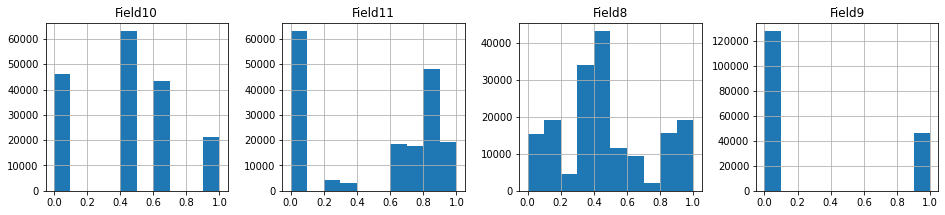

In [62]:
# Perform the same pre-processing of the numeric attributes
X_kaggle_data[columns_to_scale] = scaler.fit_transform(X_kaggle_data[columns_to_scale])
X_kaggle_data[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [63]:
# Test the Kaggle dataframe to ensure it has the indentical set of columns with X_original
X_kaggle_data = pd.get_dummies(X_kaggle_data)
X_kaggle_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173836 entries, 0 to 173835
Data columns (total 580 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Field7                 int64  
 1   Field8                 float64
 2   Field9                 float64
 3   Field10                float64
 4   Field11                float64
 5   CoverageField1A        int64  
 6   CoverageField1B        int64  
 7   CoverageField2A        int64  
 8   CoverageField2B        int64  
 9   CoverageField3A        int64  
 10  CoverageField3B        int64  
 11  CoverageField4A        int64  
 12  CoverageField4B        int64  
 13  CoverageField5A        int64  
 14  CoverageField5B        int64  
 15  CoverageField6A        int64  
 16  CoverageField6B        int64  
 17  CoverageField11A       int64  
 18  CoverageField11B       int64  
 19  SalesField1A           int64  
 20  SalesField1B           int64  
 21  SalesField2A           int64  
 22  SalesField2B       

In [64]:
columns_original = X_original.columns.tolist()
columns_kaggle = X_kaggle_data.columns.tolist()
print('Attributes in the training data frame but not in the Kaggle test data frame:')
set(columns_original).difference(set(columns_kaggle))

Attributes in the training data frame but not in the Kaggle test data frame:


set()

In [65]:
print('Attributes in the Kaggle test data frame but not in the training data frame:')
set(columns_kaggle).difference(set(columns_original))

Attributes in the Kaggle test data frame but not in the training data frame:


set()

In [66]:
# Convert the dataframe to numpy array before the final prediction step
X_test_kaggle = X_kaggle_data.to_numpy()
print("X_test_kaggle.shape: {}".format(X_test_kaggle.shape))

X_test_kaggle.shape: (173836, 580)


In [67]:
predictions_kaggle = final_model.predict_proba(X_test_kaggle)[:,1]
y_submission_kaggle['QuoteConversion_Flag'] = predictions_kaggle
print("y_submission_kaggle.shape: {}".format(y_submission_kaggle.shape))

y_submission_kaggle.shape: (173836, 2)


In [68]:
# Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'

In [69]:
submission_file = y_submission_kaggle.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20200514-0034.csv


In [70]:
if notifyStatus: email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [71]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 1 day, 7:25:22.406134
